![alt text](https://i.imgur.com/1WaY7aA.png)

---



---



## Data Science and AI
## Lab 6.1: K-Means by the algorithm

INSTRUCTIONS:

- Replace the `___` with proper code to run the cells
- Observe and understand the results
- Answer the questions

In [7]:
## Import Libraries

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn import datasets
import seaborn as sns

In [8]:
## Load the Iris dataset

# Load the Iris dataset from sklearn
iris = datasets.load_iris()

In [9]:
## Get some description about the data

print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [10]:
## Convert data into a DataFrame

# Declare the columns names
columns = 'Sepal_Length Sepal_Width Petal_Length Petal_Width'.split()

# Load the dataset as a pandas data frame
X = pd.DataFrame(iris.data, columns = columns)

In [11]:
## Check data

# About X
print('X is a %s' % type(X))
print('X has %d rows and %d columns' % X.shape)
print('Basic Statistics about X%s' % ('_'*50))
print(X.describe())
print('')
print('Sample of X%s' % ('_'*50))
print(X.head())

X is a <class 'pandas.core.frame.DataFrame'>
X has 150 rows and 4 columns
Basic Statistics about X__________________________________________________
       Sepal_Length  Sepal_Width  Petal_Length  Petal_Width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.057333      3.758000     1.199333
std        0.828066     0.435866      1.765298     0.762238
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000

Sample of X__________________________________________________
   Sepal_Length  Sepal_Width  Petal_Length  Petal_Width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6         

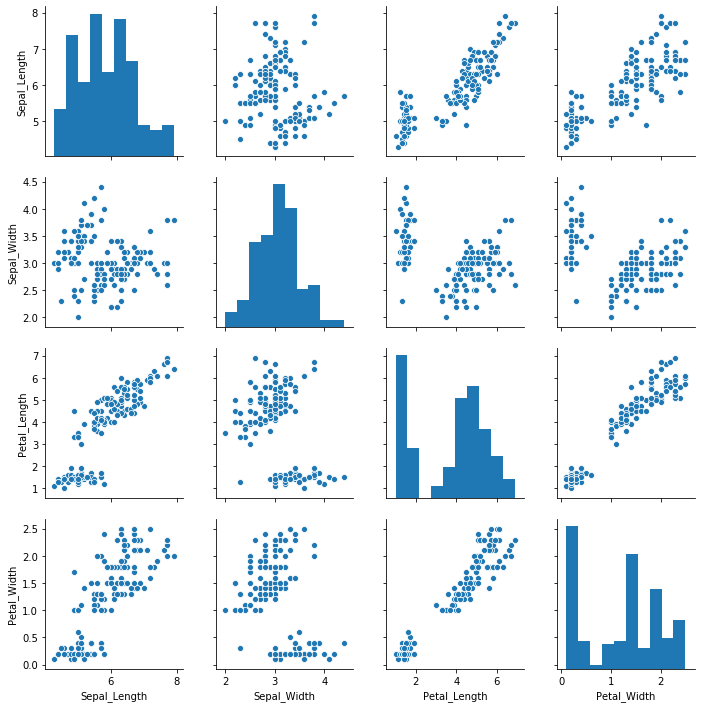

In [12]:
## Visualise the data points

# visualise features in pairs
sns.pairplot (X) 
# which method 'plots' all the features in 'pairs'? Hint: Check the Seaborn library.
plt.show()

### Question: What are other important things to know about the data? Comment on:
- Types
- Availability
- Dispersion and Distribution

### Question: Which features could/should be used to cluster the data points?

In [45]:
## Create some supporting functions

# Create new centroids randomly for all the K clusters including all dimensions
def create_centroids(K, features):
    # start with No centroids
    centroids = []
    # need one centroid for each cluster
    for i in range(K):
        # it can be multi-dimensional
        dimensions = []
        for f in features:
            # create a random number between the minimum and maximum of each feature
            x = np.random.uniform(X[f].min(),X[f].max()) 
            dimensions.append(x)
        # add all dimensions for the centroids of each cluster
        centroids.append(dimensions)

    return centroids

In [46]:
def print_centroids(centroids):
    global step
    if show_steps:
        print('(Step) Step %d' % step)
        for c in centroids:
            print(', '.join(['%.3f' % f for f in c]))
        step += 1

The **Euclidean distance** between points `p` and `q` is the length of the line segment connecting them ($\overline{pq}$).

In **Cartesian coordinates**, if $p = (p_1, p_2,..., p_n)$ and $q = (q_1, q_2,..., q_n)$ are two points in **Euclidean n-space**, then the distance `d` from `p` to `q`, or from `q` to `p` is given by the **Pythagorean formula**:

$$
{\displaystyle {\begin{aligned}d(\mathbf {p} ,\mathbf {q} )=d(\mathbf {q} ,\mathbf {p} )&={\sqrt {(q_{1}-p_{1})^{2}+(q_{2}-p_{2})^{2}+\cdots +(q_{n}-p_{n})^{2}}}\\[8pt]&={\sqrt {\sum _{i=1}^{n}(q_{i}-p_{i})^{2}}}.\end{aligned}}}
$$

In [55]:
# Identify the closest centroid for a given data point
def closest_centroid(x, centroids):
    distances = []
    # convert x to a numpy.array; x contains all the features of a data point
    p = np.array(x)
    for c in centroids:
        # convert c to a numpy.array; c contains the coordinates for all the features
        q = np.array(c)
        # calculate the Euclidean distance between data point `x` and centroid `c`
        d = np.sqrt(np.square(p - q).sum()) # Hint: consider that the data has been converted to NumPy Arrays
        # add the distance for each centroid
        distances.append(d)

    # return the position (cluster) which has the smallest distance
    return np.array(distances).argmin()

In [59]:
# recalculate all the centroids based on the mean of the members of each cluster
def update_centroid(X, y, centroids):
    c = []
    # for each of the existing centroids
    for i in range(len(centroids)):
        # check if any object was assigned to a cluster
        if X[y == i].shape[0]:
            dimensions = []
            # for all the features
            for f in X.columns:
                # calculate the mean
                x = X[f][y == i].mean() #
                dimensions.append(x)
            c.append(dimensions)
        # if a cluster got no members
        else:
            # keep the previous coordinates
            c.append(centroids[i]) #

    return c

In [60]:
# plot a chart of the data points and centroids either generic or identifying the clusters
# NOTE: for visualisation purposes, only consider the first two features
def plot_data(ax, X, y, centroids, show_clusters = True):
    # unpack the coordinates of the centroids
    a = [z[0] for z in centroids]
    b = [z[1] for z in centroids]

    # show distinct colours if asked to identify the clusters
    if show_clusters:
        colours = 'rgbykcm'
        for i in range(len(centroids)):
            ax.scatter(X[features[0]][y == i], X[features[1]][y == i], c = colours[i], label = 'Cluster %d' % i)
    # show data points without cluster identification
    else:
        ax.scatter(X[features[0]], X[features[1]], label = 'Data Point')
        
    # label the features
    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])

    # identify the centroids
    ax.scatter(a, b, c = 'k', linewidths = 5, marker = 'x', label = 'Centroid')
    for i in range(len(a)):
        c = colours[i] if show_clusters else 'k'
        ax.axvline(x = a[i], color = c, linestyle = '--', linewidth = 1)
        ax.axhline(y = b[i], color = c, linestyle = '--', linewidth = 1)

    # create a text to show the centroids' coordinates
    t = '\n'.join(['%d: (%.3f, %.3f)' % (i, a, b) for (i, (a, b)) in enumerate(centroids)])
    ax.text(7.2, 1, t)

    ax.legend()

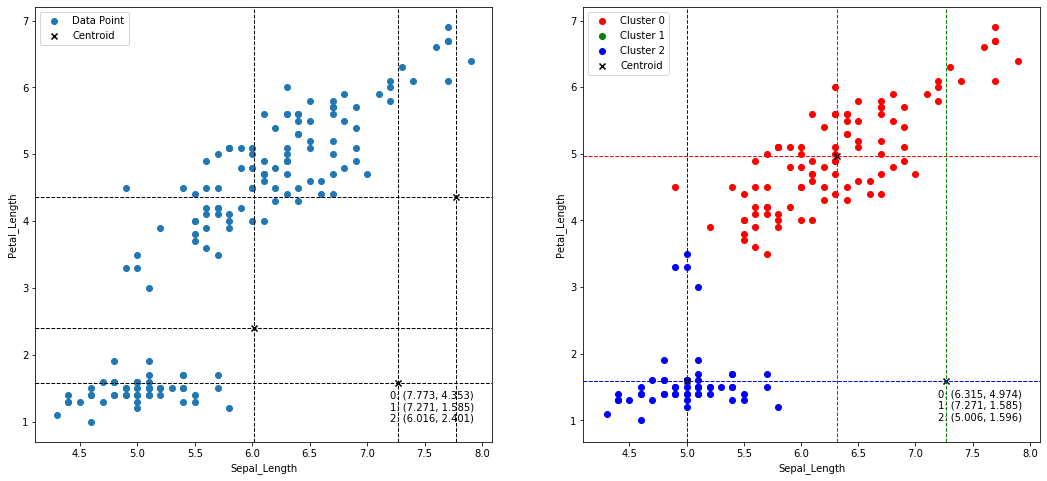

In [61]:
## K_Means
## Note that the comments match the outlined K-Means Algorithm in the presentation

# 1. Define the number of clusters `K`
K = 3

# list the features to be used
features = ['Sepal_Length', 'Petal_Length']

# 2. Select `K` cluster centres randomly
centroids = create_centroids(K, features)# Create the initial centroids
centroids_list = [centroids]
# plot the data points and initial centroids (the 'Before')
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 8))
plot_data(axes[0], X[features], None, centroids, False)

# repeat util makes no moves
while True:
    # 3. Calculate the distance between each data point and cluster centres
    # 4. Assign the data point to the cluster whose distance from its centre is minimum
    y = X[features].apply(lambda x: closest_centroid(x, centroids), axis=1).values
    
    # this can be a bit hardcore, think about it for a while
            # Hints: the `apply()` method with a `lambda` function and returning some value
            # Note: `for` loops are acceptable but slow
    
    # move the known assignment be the previous state, for post comparison
    old_c = centroids.copy()
    
    # 5. Recalculate all new cluster centres by averaging the objects of each cluster
    centroids = update_centroid (X[features], y, centroids) # Update the centroids
    centroid_list.append(centroids)
    # 6. Repeat steps 3 to 5 until the centroids do not change
    if old_c == centroids:
        break
        
# plot the data points identified by cluster and final centroids (the 'After')
plot_data(axes[1], X[features], y, centroids)
plt.show()

>

>

>



---



---



> > > > > > > > > © 2019 Data Science Institute of Australia


---



---



